# Motivation 
in this notebook we train a model and test the datamodules

In [1]:
import sqlite3
import numpy as np
import comet_ml

In [2]:
# load the database path
from config import settings
from pathlib import Path
settings_proc ='SETTINGS1'
settings_simu = 'SETTINGS1'
root= Path(settings.data.path["processed"])
database_path = (root /settings_simu/settings_simu.lower()).with_suffix('.db')

In [3]:
# load the metadata
conn = sqlite3.connect(database_path)
c = conn.cursor()
c.execute("SELECT * FROM metadata")
metadata = c.fetchone()
fs, nperseg, filter_order, lpf, freq, SNR = metadata
freq_axis = np.frombuffer(freq, dtype=np.float64)



In [4]:
from psm.models.prepare_data import CreateTransformer,PSDDataModule,PSDDataset
# let's create the transformer
transformer = CreateTransformer(database_path, freq=freq_axis, freq_min=0, freq_max=150)
transform_psd = transformer.transform_psd
transform_label = transformer.label_transform
input_dim = transformer.dimension_psd()
dm = PSDDataModule(database_path, transform_psd, transform_label, batch_size=32)
dm.setup()

# Create dataloaders
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()

# Print some details
print(f"Number of training samples: {len(dm.train_dataset)}")
print(f"Number of validation samples: {len(dm.val_dataset)}")
print(f"Number of test samples: {len(dm.test_dataset)}")

# Get a batch of data
for batch in train_dl:
    data, label = batch
    print(f"Shape of data from train_dl: {data.shape}")
    print(f"Shape of label from train_dl: {label.shape}")
    break


Number of training samples: 16000
Number of validation samples: 4000
Number of test samples: 4000
Shape of data from train_dl: torch.Size([32, 385])
Shape of label from train_dl: torch.Size([32])


In [18]:
anoumalous_dl = PSDDataset(database_path, transform=transform_psd, transform_label=transform_label,
                           anomaly_level='*',stage='anomaly')
test_dl = PSDDataset(database_path, transform=transform_psd, transform_label=transform_label,
                           stage='test')
len(test_dl)

4000

# pytorch model definition

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

class DenseSignalClassifier(nn.Module):
    def __init__(self, num_classes:int,
                  input_dim:int, 
                  dense_layers:list, 
                  dropout_rate:float=0.2, 
                 batch_norm:bool=True, 
                 activation=nn.ReLU(), l1_reg:float=0.01, 
                 temperature:float=1.0):
        super(DenseSignalClassifier, self).__init__()

        self.temperature = temperature
        self.l1_reg = l1_reg

        layers = []
        in_features = input_dim
        for units in dense_layers:
            layers.append(nn.Linear(in_features, units))
            if batch_norm:
                layers.append(nn.BatchNorm1d(units))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
            in_features = units

        self.encoder = nn.Sequential(*layers)
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x ):
        features = self.encoder(x)
        logits = self.classifier(features) 
        final_layer = F.softmax(logits, dim=1)
        return final_layer, logits
       
        

    def l1_regularization(self):
        return sum(p.abs().sum() for p in self.parameters())*self.l1_reg



# lightning wrapper

In [7]:
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.mixture import GaussianMixture as GM
from torchmetrics import ConfusionMatrix

import torchmetrics

class DenseSignalClassifierModule(pl.LightningModule):
    def __init__(self, num_classes:int, input_dim:int, dense_layers:list, 
                 dropout_rate:float=0.2, batch_norm:bool=True, activation=nn.ReLU(),
                 l1_reg:float=0.01, temperature:float=1.0, lr:float=0.001):
        super().__init__()

        self.model = DenseSignalClassifier(num_classes=num_classes, 
                                           input_dim=input_dim, 
                                           dense_layers=dense_layers, 
                                           dropout_rate=dropout_rate, 
                                           batch_norm=batch_norm, 
                                           activation=activation,
                                           l1_reg=l1_reg, 
                                           temperature=temperature)
        self.save_hyperparameters(ignore=['model'])
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_prediction = []
        self.test_target = []

    def forward(self, x):
        return self.model(x)

    def _common_step(self, batch, batch_idx, stage):
        data, target = batch
        prediction,feature = self(data)
        loss = self.criterion(prediction, target)
        
        # Add L1 regularization
        loss +=  self.model.l1_regularization()

        # Compute accuracy
        acc = self.train_acc(prediction.argmax(dim=1), target)
        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log(f'{stage}_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'feature':feature, 'target':target, 'prediction':prediction}



    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')['loss']

    def test_step(self, batch, batch_idx):
        output = self._common_step(batch, batch_idx, 'test')
        target = output['target']
        prediction = output['prediction']
        self.test_prediction.append(prediction.argmax(dim=1))
        self.test_target.append(target)
        return {'target':target, 'prediction':prediction}
    
    def on_test_epoch_end(self):
        # Compute and log the confusion matrix
        targets = torch.cat(self.test_target)
        predictions = torch.cat(self.test_prediction)
        print(targets.shape, predictions.shape)
        
        self.logger.experiment.log_confusion_matrix(
            y_true=targets,
            y_predicted=predictions,
            title="Confusion Matrix",
            row_label="Actual", column_label="Predicted",
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-07)
        scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, 'min'),
            'monitor': 'val_loss',  # Metric to monitor
            'interval': 'epoch',  # The scheduler will be updated after each epoch
            'frequency': 1,  # The frequency of the scheduler updates in number of epochs
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    


In [8]:
# let's define a functio that create the callbacks we are using 
# Early stopping and checkpointing, reduce learning rate on plateau
# logging to mlflow
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CometLogger
from config import settings
from pathlib import Path

model_path = Path(settings.data.path["model"])

def create_callbacks_loggers(tags=None,settings=settings):
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=False,
        mode='min'
    )

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='best-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min',
        dirpath=model_path/'model',
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    logger = CometLogger(
        api_key=settings.comet['api_key'],
        workspace=settings.comet['workspace'],
        project_name=settings.comet['project_name'])

    res = ([early_stop_callback, checkpoint_callback, lr_monitor],
               logger)

    return res


In [22]:
class AD_GMM():
    """ a class that define the gmm training and prediction for anomaly detection
    uses model for feature extraction"""
    def __init__(self, num_classes:int, model ):
        self.gmm = GM(n_components=num_classes, covariance_type='full')
        self.model = model
    def fit(self, dataloader):
        features = []
        self.model.eval()
        with torch.no_grad():
            for batch in dataloader:
                data, target = batch
                _, feature = self.model(data)
                feature = feature.detach().numpy()
                features.append(feature)
        features = np.concatenate(features)
        self.gmm.fit(features)
    
    def infere(self,data):
        if data.ndim == 1:
            data = data.reshape(1,-1)
        _, feature = self.model(data)
        feature = feature.detach().numpy()
        log = self.gmm.score_samples(feature)
        return log




In [23]:
ad_system = AD_GMM(num_classes=20, model=best_model)
ad_system.fit(train_dl)



In [24]:
import pandas as pd
df_res = pd.DataFrame(columns=['system_name', 'anomaly_level', 'log_likelihood'])

for psd,system_name,anomaly_level in anoumalous_dl:

    log_likelihood = ad_system.infere(psd)
    df_res = pd.concat([df_res, pd.DataFrame({'system_name':system_name, 'anomaly_level':anomaly_level, 'log_likelihood':log_likelihood})]) 
for psd,system_name in test_dl:
    log_likelihood = ad_system.infere(psd)
    df_res = pd.concat([df_res, pd.DataFrame({'system_name':system_name, 'anomaly_level':0, 'log_likelihood':log_likelihood})])

In [20]:
from psm.eval.aucs_computation import compute_auc_for_levels

# Assume df is your DataFrame
auc_results_df = compute_auc_for_levels(df_res)


In [21]:
auc_results_df

anomaly_level,0.00,0.01,0.03,0.05,0.07,0.09,0.11,0.13
system_name,,,,,,,,
0,0.5,0.543,0.795,0.937,0.981,0.993,0.998,1.000
1,0.5,0.487,0.813,0.953,0.986,0.992,0.995,0.996
2,0.5,0.561,0.843,0.967,0.990,0.998,1.000,1.000
3,0.5,0.542,0.830,0.947,0.979,0.996,1.000,1.000
4,0.5,0.531,0.857,0.969,0.993,0.995,0.995,0.995
5,0.5,0.590,0.884,0.981,0.997,1.000,1.000,1.000
6,0.5,0.546,0.825,0.955,0.983,0.996,1.000,1.000
7,0.5,0.644,0.939,0.998,1.000,1.000,1.000,1.000
8,0.5,0.603,0.836,0.940,0.970,0.987,0.993,0.995


In [12]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


# Specify trainer details
callbacks,logger  = create_callbacks_loggers()
trainer = Trainer(max_epochs=2,callbacks=callbacks, logger=logger)

# Instantiate your data module
dm = PSDDataModule(database_path=database_path,transform=transform_psd,
                   transform_label=transform_label, batch_size=64)

hyper_params = {'input_dim':input_dim, 'dense_layers':[248,128, 64, 32],
                'dropout_rate':0, 'num_classes':20, 'lr':0.002,
                'batch_norm':True, 'activation':nn.ReLU(), 'l1_reg':1e-4}
# Instantiate your model
model = DenseSignalClassifierModule(**hyper_params)

# Start training
trainer.fit(model, dm)
# load the best model according to the validation loss
checkpoint_path = trainer.checkpoint_callback.best_model_path

best_model = DenseSignalClassifierModule.load_from_checkpoint(checkpoint_path)
trainer.logger.experiment.log_asset(checkpoint_path,step=trainer.global_step)
trainer.logger.experiment.log_model("best_model", checkpoint_path)
trainer.test(best_model, dm)

# After training, you can also test your model
logger.experiment.end()

CometLogger will be initialized in online mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
  rank_zero_warn(
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/yacinebelhadj/psm-mdof/0712d564a0d74c4abd001c552babf141

/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/yacine/Documents/

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/yacine/miniconda3/envs/PBSHM_Mdof/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  23%|██▎       | 57/250 [00:01<00:04, 42.27it/s, v_num=f141]

COMET WARNING: Error exporting current conda environment


Epoch 1: 100%|██████████| 250/250 [00:04<00:00, 53.68it/s, v_num=f141, val_loss=2.800, val_acc=0.449, train_loss=2.280, train_acc=0.985]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 250/250 [00:04<00:00, 53.07it/s, v_num=f141, val_loss=2.800, val_acc=0.449, train_loss=2.280, train_acc=0.985]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/yacinebelhadj/psm-mdof/0712d564a0d74c4abd001c552babf141
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [50]      : (2.223769187927246, 3.2458279132843018)
COMET INFO:     lr-Adam        : 0.002
COMET INFO:     train_acc [2]  : (0.7826250195503235, 0.9848750233650208)
COMET INFO:     train_loss [2] : (2.280822515487671, 2.612283229827881)
COMET INFO:     val_acc [2]    : (0.20475000143051147, 0.4492500126361847)
COMET INFO:     val_loss [2]   : (2.797516107559204, 3.084435224533081)
COMET INFO:   Parameters:
COMET INFO:     activation   : ReLU()
COMET INFO:     batch_norm   : True
COMET INFO:     dense_layers : [2

Testing DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 101.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.45124998688697815    │
│         test_loss         │     2.795159101486206     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/yacinebelhadj/psm-mdof/0712d564a0d74c4abd001c552babf141
COMET INFO:   Metrics:
COMET INFO:     test_acc  : 0.45124998688697815
COMET INFO:     test_loss : 2.795159101486206
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     activation   : ReLU()
COMET INFO:     batch_norm   : True
COMET INFO:     dense_layers : [248, 128, 64, 32]
COMET INFO:     dropout_rate : 0
COMET INFO:     input_dim    : 385
COMET INFO:     l1_reg       : 0.0001
COMET INFO:     lr           : 0.002
COMET INFO:     num_classes  : 20
COMET INFO:     temperature  : 1.0
COMET INFO:   Uploads:

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import tuner
import mlflow
# Instantiate your data module
dm = PSDDataModule(database_path=database_path,transform=transform_psd,
                   transform_label=transform_label, batch_size=64)

# Instantiate your model
model = DenseSignalClassifierModule(input_dim=input_dim, dense_layers=[248,248,248,128, 64, 32], 
                                    dropout_rate=0, num_classes=20, lr=0.001,
                                    batch_norm=True, activation=nn.ReLU(), l1_reg=1e-3
                                    )

# Initialize the trainer
trainer = Trainer()

# Run learning rate finder
lr_finder = tuner.Tuner(trainer).lr_find(model=model, datamodule=dm)

# Inspect results
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.learning_rate = new_lr



# After training, you can also test your model


ModuleNotFoundError: No module named 'mlflow'

In [ ]:
data, label = next(iter(dm.train_dataloader()))

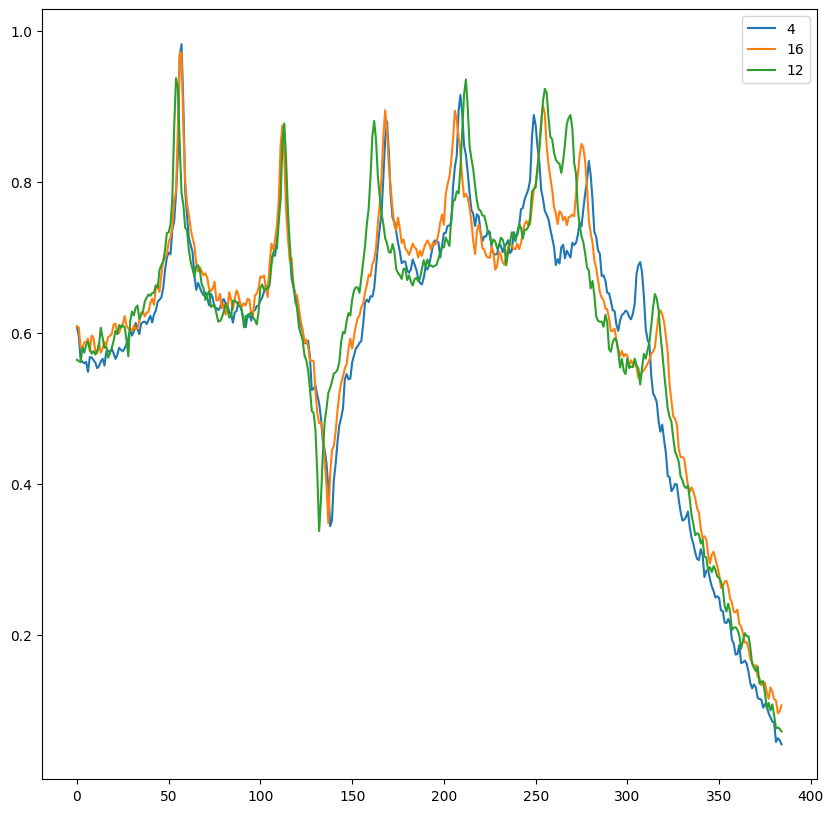

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(data[0].numpy(), label=label[0].numpy())
plt.plot(data[1].numpy(), label=label[1].numpy())
plt.plot(data[2].numpy(), label=label[2].numpy())
plt.legend()